# Illustration of the re-ranking of stereoisomers using LC-MS$^2$Struct

As examples we use three spectra in our MassBank (MB) dataset:

| **Index** | **Spectrum ID** | **MB-subset** | **PubChem ID** | **InChIkey first block (2D)** | **InChIKey second block (3D)** | **Retention time (RT)** | **Precursor type** | **Number of LC-MS experiments** |
| --- | --- | --- | --- | --- | --- | ---: | --- | ---: |
| 1. | BS02391126 | BS_000 | [134751759](https://pubchem.ncbi.nlm.nih.gov/compound/134751759) | NCJNNMWJQIKYLO | FRVSQPBBSA | 7.64 min | [M-H]- | 4 |
| 2. | BS64681001 | BS_000 | [134751760](https://pubchem.ncbi.nlm.nih.gov/compound/134751760) | NCJNNMWJQIKYLO | WYFUIKBSSA | 8.63 min | [M-H]- | 8 | 
| 3. | PR75447353 | PR_002 | [139291977](https://pubchem.ncbi.nlm.nih.gov/compound/139291977) | NCJNNMWJQIKYLO | XCVCLJGOSA | 4.77 min | [M+H]+ | 2 |

The first two spectra are measured under the same LC- and MS-conditions (BS_000) and therefore there RTs are comparable. We can see that there is a significant RT difference of about a minute. In our experimental setup, the candidate sets associated with the three spectra are equal (all share the same molecular formula: C36H32O19). The shared candidate set contains only three candidates: 134751759, 134751760 and 139291977, which are the three stereoisomers sharing the same 2D structure (NCJNNMWJQIKYLO). 

In this notebook we investigate whether LC-MS$^2$Struct can identify the correct stereoisomer for each spectrum. In our evaluation each spectrum can appear in multiple LC-MS experiments (those are generated by sampling from the respective MB-subset). The examples we study here appear between 2 and 8 times in differen LC-MS experiments. The max-marginals used here are produced in conjunctio to the SIRIUS MS$^2$ scorer.

### Isomeric SMILES of the ground truth compounds

| **Index** | **Isomeric SMILES** | 
| --- | --- |
| 1. | ```C1=CC(=CC=C1/C=C/C(=O)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2O[C@@H]3[C@H]([C@@H]([C@H](O[C@H]3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O``` | 
| 2. | ```C1=CC(=CC=C1/C=C\C(=O)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2O[C@@H]3[C@H]([C@@H]([C@H](O[C@H]3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O``` | 
| 3. | ```C1=CC(=CC=C1/C=C/C(=O)OC2C(C(C(OC2OC3C(C(C(OC3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O``` | 

In [88]:
import sqlite3
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

# RDKIT
from rdkit.Chem import MolFromSmiles, Draw, MolFromInchi, MolToSmiles, AssignStereochemistry, MolFromSmarts
from rdkit.Chem.rdDepictor import Compute2DCoords
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit import __version__ as rdkit__version
print("RDKit:", rdkit__version)
from IPython.display import SVG

# Matchms
from matchms import Spectrum
from matchms import __version__ as matchms__version
print("matchms:", matchms__version)

mb_db_fn = "/home/bach/Documents/doctoral/projects/lcms2struct_experiments/data/massbank.sqlite"
spec_dir = "/home/bach/Documents/doctoral/projects/msms_rt_ssvm_NMI/supplementary_material"

RDKit: 2021.03.1
matchms: 0.9.2


## Load the MS$^2$ spectra

In [59]:
def load_from_peaklist(fn):
    mzs = []
    intensities = []
    with open(fn, "r") as file: 
        for line in file.readlines():
            if len(line.strip()) > 0:
                mz, intensity = line.strip().split("\t")
                mzs.append(float(mz))
                intensities.append(float(intensity))
                
    return Spectrum(np.array(mzs), np.array(intensities))
            
specs = []
    
# BS02391126
specs.append(load_from_peaklist(os.path.join(spec_dir, "BS02391126.peaks")))
specs[-1].set("Precursor type", "[M-H]-")
specs[-1].set("Retention time", 7.64)
specs[-1].set("Spectrum id", "BS02391126")
specs[-1].set("MB-group", "BS_000")
specs[-1].set("inchikey1", "NCJNNMWJQIKYLO")
specs[-1].set("inchikey2", "FRVSQPBBSA")
specs[-1].set("iso_smiles", "C1=CC(=CC=C1/C=C/C(=O)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2O[C@@H]3[C@H]([C@@H]([C@H](O[C@H]3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O")


# BS64681001
specs.append(load_from_peaklist(os.path.join(spec_dir, "BS64681001.peaks")))
specs[-1].set("Precursor type", "[M-H]-")
specs[-1].set("Retention time", 8.63)
specs[-1].set("Spectrum id", "BS64681001")
specs[-1].set("MB-group", "BS_000")
specs[-1].set("inchikey1", "NCJNNMWJQIKYLO")
specs[-1].set("inchikey2", "WYFUIKBSSA")
specs[-1].set("iso_smiles", "C1=CC(=CC=C1/C=C\C(=O)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2O[C@@H]3[C@H]([C@@H]([C@H](O[C@H]3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O")

# PR75447353
specs.append(load_from_peaklist(os.path.join(spec_dir, "PR75447353.peaks")))
specs[-1].set("Precursor type", "[M+H]+")
specs[-1].set("Retention time", 4.77)
specs[-1].set("Spectrum id", "PR75447353")
specs[-1].set("MB-group", "PR_002")
specs[-1].set("inchikey1", "NCJNNMWJQIKYLO")
specs[-1].set("inchikey2", "XCVCLJGOSA")
specs[-1].set("iso_smiles", "C1=CC(=CC=C1/C=C/C(=O)OC2C(C(C(OC2OC3C(C(C(OC3OC4=CC=C(C=C4)C5=CC(=O)C6=C(C=C(C=C6O5)O)O)C(=O)O)O)O)C(=O)O)O)O)O")

### Plot the MS$^2$ spectra

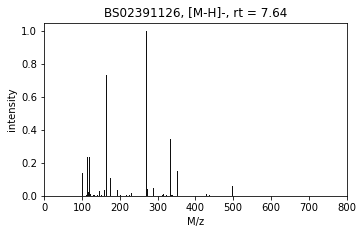

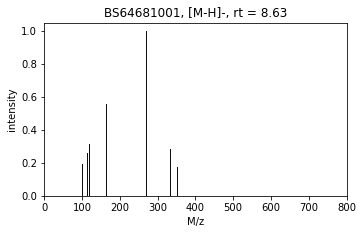

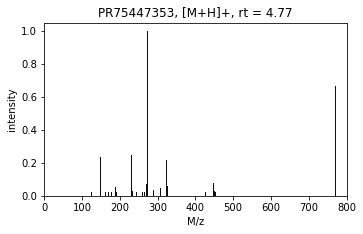

In [57]:
def my_spec_plot(spec, max_mz=None, fig_height=3):
    fig = spec.plot()
    
    # Modify plot
    if max_mz is not None:
        fig.axes[0].set_xlim(0, max_mz)
    fig.set_figheight(fig_height)
    fig.axes[0].set_title("%s, %s, rt = %.2f" % (spec.get("Spectrum id"), spec.get("Precursor type"), spec.get("Retention time")))

    return fig

figs = [my_spec_plot(spec, max_mz=800) for spec in specs]

In [60]:
for ext in ["pdf", "svg"]:
    for spec, fig in zip(specs, figs):
        fig.savefig(os.path.join(".", os.extsep.join(["spectrum__%s" % spec.get("Spectrum id"), ext])))